# KerasでDCGANを試してみる

[こちらのコード](https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py)を参考

## 必要なパッケージのインポート

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math
import os
import keras.backend as K
import tensorflow as tf
K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

## Generatorの定義

In [2]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

## Discriminatorの定義

In [3]:
def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

## GeneratorとDiscriminatorを結合

In [4]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

## 生成画像表示用の関数

In [5]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

## 学習
### MNISTのロード

In [6]:
(X_train, y_train), (_, _) = mnist.load_data()

### 前処理

In [7]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

### ここからがメイン

In [ ]:
BATCH_SIZE = 32
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = 'generated_images/'

discriminator = discriminator_model()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

# generator + discriminator (discriminator部分の重みは固定)
discriminator.trainable = False
generator = generator_model()
dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)

for epoch in range(NUM_EPOCH):
    
    for index in range(num_batches):
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = generator.predict(noise, verbose=0)
        #generated_images = generated_images.reshape(generated_images.shape[0], 1, generated_images.shape[1], generated_images.shape[2])
        
        # 生成画像を出力
        if index % 500 == 0:
            image = combine_images(generated_images)
            image = image*127.5 + 127.5
            if not os.path.exists(GENERATED_IMAGE_PATH):
                os.mkdir(GENERATED_IMAGE_PATH)
            Image.fromarray(image.astype(np.uint8)).save(GENERATED_IMAGE_PATH + "%04d_%04d.png" % (epoch, index))
        
        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)
        
        # generatorを更新
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
        print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))
        
    generator.save_weights('generator.h5')
    discriminator.save_weights('discriminator.h5')

/root/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  app.launch_new_instance()


Number of batches: 1875
epoch: 0, batch: 0, g_loss: 0.713174, d_loss: 0.750460
epoch: 0, batch: 1, g_loss: 0.674584, d_loss: 0.710865
epoch: 0, batch: 2, g_loss: 0.648558, d_loss: 0.675732
epoch: 0, batch: 3, g_loss: 0.617694, d_loss: 0.654592
epoch: 0, batch: 4, g_loss: 0.590653, d_loss: 0.630928
epoch: 0, batch: 5, g_loss: 0.560689, d_loss: 0.607127
epoch: 0, batch: 6, g_loss: 0.553312, d_loss: 0.605089
epoch: 0, batch: 7, g_loss: 0.535394, d_loss: 0.592745
epoch: 0, batch: 8, g_loss: 0.521874, d_loss: 0.573264
epoch: 0, batch: 9, g_loss: 0.519130, d_loss: 0.580912
epoch: 0, batch: 10, g_loss: 0.512763, d_loss: 0.567232
epoch: 0, batch: 11, g_loss: 0.522188, d_loss: 0.552274
epoch: 0, batch: 12, g_loss: 0.534759, d_loss: 0.550435
epoch: 0, batch: 13, g_loss: 0.517226, d_loss: 0.555679
epoch: 0, batch: 14, g_loss: 0.540149, d_loss: 0.550400
epoch: 0, batch: 15, g_loss: 0.554624, d_loss: 0.537687
epoch: 0, batch: 16, g_loss: 0.552601, d_loss: 0.549028
epoch: 0, batch: 17, g_loss: 0.571

In [28]:
image_batch.shape

(32, 1, 28, 28)

In [30]:
generated_images.shape

(32, 28, 28, 1)

In [31]:
a = generated_images.reshape(generated_images.shape[0], 1, generated_images.shape[1], generated_images.shape[2])

In [38]:
X_train.shape

(60000, 28, 28, 1)

In [17]:
!nvidia-smi

Wed Sep 27 04:34:37 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 0000:04:00.0     Off |                    0 |
| N/A   67C    P0   186W / 250W |    615MiB / 22939MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 0000:82:00.0     Off |                    0 |
| N/A   68C    P0   190W / 250W |    615MiB / 22939MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [22]:
!ls generated_images/

0000_0000.png  0004_0000.png  0008_0000.png  0012_0000.png  0016_0000.png
0000_0500.png  0004_0500.png  0008_0500.png  0012_0500.png  0016_0500.png
0000_1000.png  0004_1000.png  0008_1000.png  0012_1000.png  0016_1000.png
0000_1500.png  0004_1500.png  0008_1500.png  0012_1500.png  0016_1500.png
0001_0000.png  0005_0000.png  0009_0000.png  0013_0000.png  0017_0000.png
0001_0500.png  0005_0500.png  0009_0500.png  0013_0500.png  0017_0500.png
0001_1000.png  0005_1000.png  0009_1000.png  0013_1000.png  0017_1000.png
0001_1500.png  0005_1500.png  0009_1500.png  0013_1500.png  0017_1500.png
0002_0000.png  0006_0000.png  0010_0000.png  0014_0000.png  0018_0000.png
0002_0500.png  0006_0500.png  0010_0500.png  0014_0500.png  0018_0500.png
0002_1000.png  0006_1000.png  0010_1000.png  0014_1000.png  0018_1000.png
0002_1500.png  0006_1500.png  0010_1500.png  0014_1500.png  0018_1500.png
0003_0000.png  0007_0000.png  0011_0000.png  0015_0000.png  0019_0000.png
0003_0500.png  0007_0500.png  0011_050

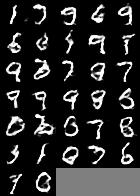

In [28]:
Image.open("generated_images/0001_1000.png")